## Inspect Prediction Results

In this notebook, we loop over all classification task predictions to detect where and how PrivBERT and other models differ in their predictions.

In [1]:
import json
import operator
import os
import random
from glob import glob
from itertools import product

import matplotlib
import numpy as np
import pandas as pd
from plotnine import (
    aes,
    element_blank,
    element_text,
    facet_wrap,
    geom_col,
    ggplot,
    labs,
    scale_fill_manual,
    theme,
    theme_bw,
)
from tqdm import tqdm


%matplotlib inline
matplotlib.rc("text", usetex=True)
random.seed(42)

In [2]:
# declare global variables
MODELS = {
    "bert_base_uncased": "BERT",
    "roberta_base":"RoBERTa",
    "nlpaueb_legal_bert_base_uncased": "Legal-BERT",
    "saibo_legal_roberta_base": "Legal-RoBERTa",
    "mukund_privbert": "PrivBERT"
}

TASKS= {
    "opp_115": "\\textbf{OPP-115}",
    "policy_detection": "\\textbf{Policy-Detection}",
    "policy_ie_a": "\\textbf{PolicyIE-A}",
    "privacy_qa": "\\textbf{PrivacyQA}"
}


RANDOM_SEED_ITERATIONS = 10

# collect all predictions in dictionary
predictions = {}
for model in MODELS.keys():
    predictions[model] = {}
    for task in TASKS.keys():
        predictions[model][task] = []
        for index in range(RANDOM_SEED_ITERATIONS):
            with open(os.path.join("..", "runs", model, task,
                                   f"seed_{index}", "predictions.json"), "r") as input_file_stream:
                preds = json.load(input_file_stream)
                predictions[model][task].append(preds)

Now we perform comparisons of predictions on PrivBERT vs. all other models and aggregate results.

In [3]:
# create storage variables and priv_bert predictions
comparisons = {}
interesting_examples = {}
priv_bert = predictions["mukund_privbert"]

# loop across all models that are not PrivBERT
for model in tqdm(MODELS.keys()):
    if model != "mukund_privbert":
        other_model = predictions[model]
        comparisons[("mukund_privbert", model)] = {}
        interesting_examples[("mukund_privbert", model)] = {}
        
        # loop across relevant tasks
        for task in TASKS.keys():
            priv_bert_task = priv_bert[task]
            other_model_task = other_model[task]
            interesting_examples[("mukund_privbert", model)][task] = {"priv_correct": [],
                                                                      "priv_wrong": []}
            metric = np.array([0, 0, 0, 0])                    
            maybe_sort = sorted if task == "opp_115" else lambda x: x
            
            # loop across all seed combinations
            for seed_priv_bert, seed_other_model in product(range(RANDOM_SEED_ITERATIONS),
                                                            range(RANDOM_SEED_ITERATIONS)):
                predictions_priv_bert = priv_bert_task[seed_priv_bert]
                predictions_other_model = other_model_task[seed_other_model]
                
                # loop across all examples per seed combination
                for prediction_priv_bert, prediction_other_model in zip(predictions_priv_bert,
                                                                        predictions_other_model):
                    # make sanity check
                    assert prediction_priv_bert["gold_label"] == prediction_other_model["gold_label"]
                    
                    # get necessary booleans
                    priv_bert_correct = (maybe_sort(prediction_priv_bert["predicted_label"])
                                         == maybe_sort(prediction_priv_bert["gold_label"]))
                    other_model_correct = (maybe_sort(prediction_other_model["predicted_label"])
                                           == maybe_sort(prediction_other_model["gold_label"]))
                    
                    # increment frequency counts
                    if priv_bert_correct and other_model_correct:
                        metric += np.array([1, 0, 0, 0])
                    elif priv_bert_correct and not other_model_correct:
                        metric += np.array([0, 1, 0, 0])
                        interesting_examples[("mukund_privbert", model)][task]["priv_correct"].append(
                            [(seed_priv_bert, seed_other_model),
                             prediction_priv_bert, prediction_other_model])
                    elif not priv_bert_correct and other_model_correct:
                        metric += np.array([0, 0, 1, 0])
                        interesting_examples[("mukund_privbert", model)][task]["priv_wrong"].append(
                            [(seed_priv_bert, seed_other_model),
                             prediction_priv_bert, prediction_other_model])
                    else:
                        metric += np.array([0, 0, 0, 1])
            
            # save metric into comparisons dictionary
            comparisons[("mukund_privbert", model)][task] = metric / np.sum(metric)

100%|██████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.79s/it]


Now we compile results into a pandas dataframe.

In [4]:
# define latex comaparsion symbols
comparison = ["(PrivBERT, Other)", "(PrivBERT, $\\neg$ Other)",
              "($\\neg$ PrivBERT, Other)", "($\\neg$ PrivBERT, $\\neg$ Other)"]

# consolidate dataframe
df = (pd.DataFrame
      .from_dict(comparisons)
      .melt(var_name=["first_model", "second_model"], ignore_index=False)
      .reset_index()
      .rename(columns={"index": "task"}))

# make small adjustments
df["second_model"] = df["second_model"].replace(MODELS)
df["task"] = df["task"].replace(TASKS)
df["comparison"] = [comparison for _ in df.index]

# explode all internal lists and finalize
df = df.explode(["value", "comparison"])
df["comparison"] = pd.Categorical(df["comparison"], reversed(comparison))
df = df.infer_objects()

In [5]:
df

,task,first_model,second_model,value,comparison
0,\textbf{OPP-115},mukund_privbert,BERT,0.701463,"(PrivBERT, Other)"
0,\textbf{OPP-115},mukund_privbert,BERT,0.085624,"(PrivBERT, $\neg$ Other)"
0,\textbf{OPP-115},mukund_privbert,BERT,0.036413,"($\neg$ PrivBERT, Other)"
0,\textbf{OPP-115},mukund_privbert,BERT,0.176499,"($\neg$ PrivBERT, $\neg$ Other)"
1,\textbf{Policy-Detection},mukund_privbert,BERT,0.900921,"(PrivBERT, Other)"
...,...,...,...,...,...
14,\textbf{PolicyIE-A},mukund_privbert,Legal-RoBERTa,0.096119,"($\neg$ PrivBERT, $\neg$ Other)"
15,\textbf{PrivacyQA},mukund_privbert,Legal-RoBERTa,0.893369,"(PrivBERT, Other)"
15,\textbf{PrivacyQA},mukund_privbert,Legal-RoBERTa,0.008964,"(PrivBERT, $\neg$ Other)"
15,\textbf{PrivacyQA},mukund_privbert,Legal-RoBERTa,0.008230,"($\neg$ PrivBERT, Other)"


Now we plot our results.

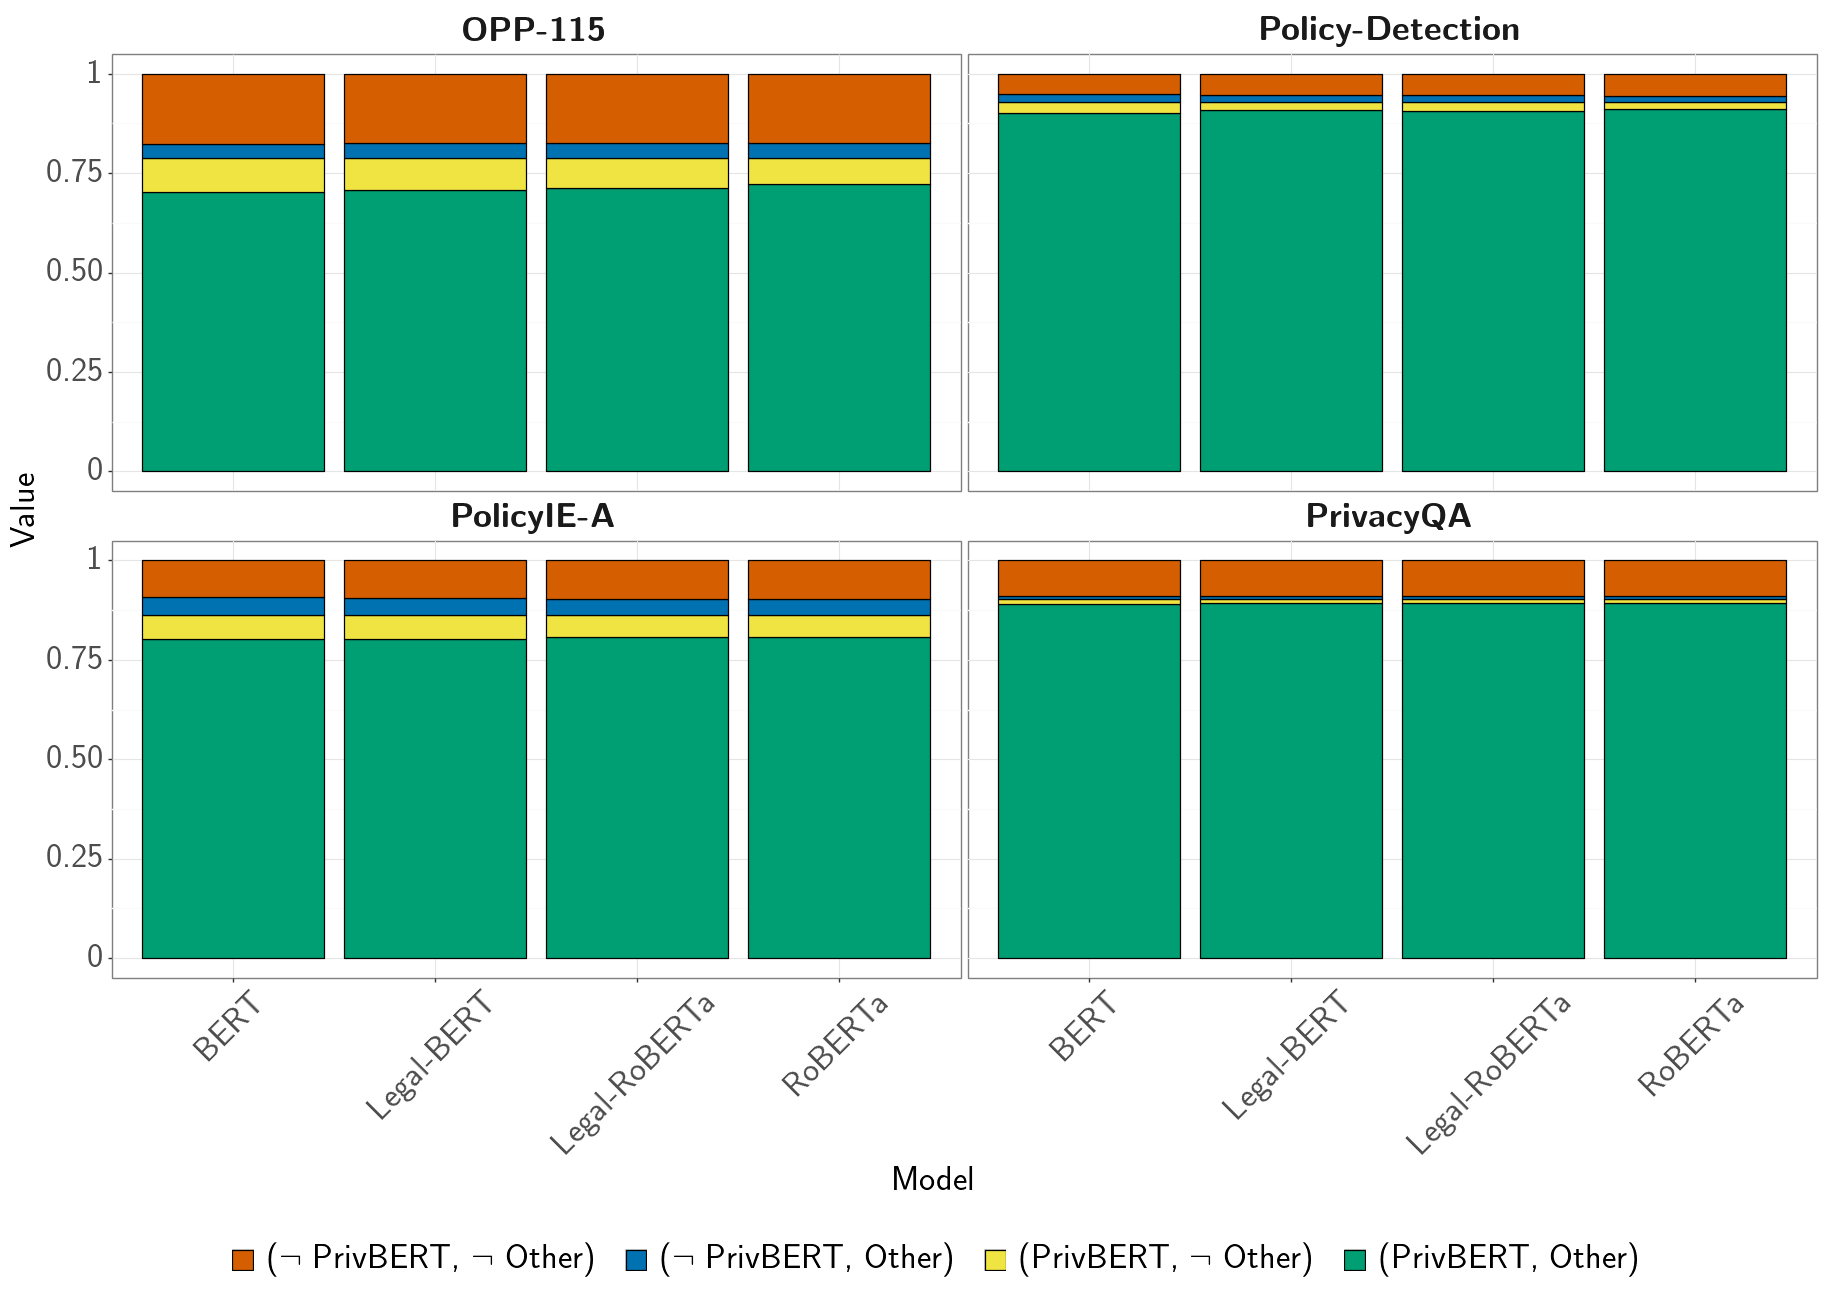

In [6]:
(
    ggplot(df, aes(x="second_model", y="value", fill="comparison"))
    + geom_col(color="black")
    + theme(axis_text_x=element_text(angle = 90), figure_size=(22, 12),
           text=element_text(size=25))
    + facet_wrap("task")
    + theme_bw()
    + theme(axis_text_x=element_text(angle = 45), figure_size=(22, 12),
            text=element_text(size=25), legend_text=element_text(margin={"l": 10}),
            legend_position=(0.5, -0.125), legend_direction="horizontal", legend_title=element_blank(),
            legend_entry_spacing=20, strip_background=element_blank())
    + scale_fill_manual(values=list(reversed(["#009e73", "#f0e442", "#0072b2", "#d55e00"])))
    + labs(x="Model", y="Value")
).draw();

Finally, we inspect some interesting examples.

In [7]:
# inspect examples where PrivBERT was right while other model was wrong
random.sample(interesting_examples[("mukund_privbert", "nlpaueb_legal_bert_base_uncased")
                                  ]["privacy_qa"]["priv_correct"], 1)

[[(6, 7),
  {'id': 14982,
   'question': 'what does groupon do with collected data? (eg, does it sell it to third parties?)                  ',
   'text': 'Send you reminders, technical notices, updates, security alerts, support and administrative messages, service bulletins, marketing messages, and requested information, including on behalf ofBusiness Partners;',
   'gold_label': 'Relevant',
   'predicted_label': 'Relevant'},
  {'id': 14982,
   'question': 'what does groupon do with collected data? (eg, does it sell it to third parties?)                  ',
   'text': 'Send you reminders, technical notices, updates, security alerts, support and administrative messages, service bulletins, marketing messages, and requested information, including on behalf ofBusiness Partners;',
   'gold_label': 'Relevant',
   'predicted_label': 'Irrelevant'}]]

In [8]:
# inspect examples where PrivBERT was right while other model was wrong
random.sample(interesting_examples[("mukund_privbert", "nlpaueb_legal_bert_base_uncased")
                                  ]["privacy_qa"]["priv_wrong"], 1)

[[(1, 5),
  {'id': 6140,
   'question': 'can other parties see my information',
   'text': 'We are not exposed to the payment information provided to our payment vendors, and this information is subject to the privacy policy applicable to the payment vendor; and',
   'gold_label': 'Irrelevant',
   'predicted_label': 'Relevant'},
  {'id': 6140,
   'question': 'can other parties see my information',
   'text': 'We are not exposed to the payment information provided to our payment vendors, and this information is subject to the privacy policy applicable to the payment vendor; and',
   'gold_label': 'Irrelevant',
   'predicted_label': 'Irrelevant'}]]